# vectorize 函数矢量化回测模型

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [3]:
def func(a, b):
    return math.sqrt(a**2 + b**2)

In [4]:
a, b = 3, 4
func(a, b)

5.0

In [10]:
a, b = [3, 4, 5], [4, 5, 6]
func_vec = np.vectorize(func)  # 通过func得到了一个矢量化函数，可以直接处理矢量数据
func_vec(a, b)
b = 5
func_vec(a, b)

array([5.83095189, 6.40312424, 7.07106781])

## 浦发银行金融量化模型

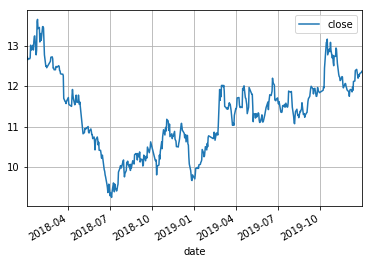

In [22]:
data = pd.read_csv('../data/pfyh.csv', header=None, names=[
    'date', 'open', 'high', 'low', 'close', 'ma5', 'ma10', 'volume'])
data['date'] = data['date'].astype('M8[D]')
data.plot(x='date', y='close', grid=True)

In [23]:
data.head()

,date,open,high,low,close,ma5,ma10,volume
0,2018-01-02,12.61,12.77,12.60,12.73,12.624,12.650,313230.53
1,2018-01-03,12.73,12.80,12.66,12.67,12.630,12.642,378391.00
2,2018-01-04,12.70,12.73,12.62,12.66,12.638,12.637,278838.03
3,2018-01-05,12.67,12.71,12.62,12.69,12.668,12.636,310267.44
4,2018-01-08,12.69,12.71,12.63,12.68,12.686,12.642,313898.88


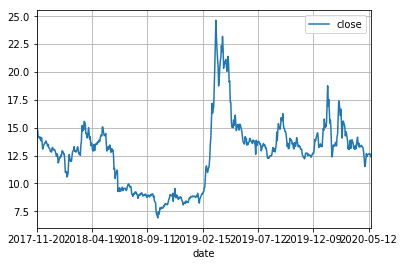

In [81]:
import tushare as ts
data = ts.get_hist_data('600088')
data = data.reset_index().sort_values(by='date')
data.plot(x='date', y='close', grid=True)
data.index = np.arange(len(data))

In [82]:
# 声明一个函数，传入一个日期参数，假设该日期为当前日期，根据已知数据，返回策略输出-1（卖出）1（买入）0（持有）
def profit(mdate):
    # 基于均线理论，判断金叉死叉，返回相应结果。
    mask = data['date']<=mdate
    if len(data[mask]) < 2:
        return 0
    today_data = data[mask].iloc[-1]
    yesday_data = data[mask].iloc[-2]
    # 昨天的5日均线与10日均线
    yma5, yma10 = yesday_data['ma5'], yesday_data['ma10']
    # 今天的5日均线与10日均线
    tma5, tma10 = today_data['ma5'], today_data['ma10']
    # 判断金叉死叉
    if (yma10>=yma5) and (tma10<=tma5): # 金叉
        return 1
    if (yma10<=yma5) and (tma10>=tma5): # 死叉
        return -1
    return 0
    
# 把profit函数矢量化处理
profit_vec = np.vectorize(profit)
result = profit_vec(data['date'])
result

array([ 0,  1,  1,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0, -1,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0

In [83]:
# 定义资产
assets = 1000000
stocks = 0
payment_price = 0
status = 0
for index, profit in enumerate(result):
    current_price = data['close'][index]
    # 如果是买入并且赔了的状态，若已经跌出5%，则强制卖出
    if status == 1:
        payment_assets = payment_price * stocks
        current_assets = current_price * stocks
        if (payment_assets > current_assets) and ((payment_assets-current_assets) > payment_assets *0.05):
            payment_price = current_price
            assets = assets + stocks * payment_price
            stocks = 0
            status = -1
            print('止损：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
                data['date'][index], current_price, assets, stocks))
    if (profit == 1) and (status != 1): # 买入
        payment_price = current_price
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print('买入：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
            data['date'][index], current_price, assets, stocks))
    if (profit == -1) and (status != -1): # 卖出
        payment_price = current_price
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print('卖出：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
            data['date'][index], current_price, assets, stocks))
print('持有：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
    data['date'][index], current_price, assets, stocks))

买入：dates:2017-11-21, curr price:14.92, assets:1.92, stocks:67024
止损：dates:2017-11-24, curr price:14.13, assets:947051.04, stocks:0
买入：dates:2017-11-24, curr price:14.13, assets:1.92, stocks:67024
卖出：dates:2017-11-27, curr price:14.09, assets:944370.08, stocks:0
买入：dates:2017-12-13, curr price:13.82, assets:8.02, stocks:68333
卖出：dates:2017-12-20, curr price:13.20, assets:902003.62, stocks:0
买入：dates:2018-01-04, curr price:13.06, assets:1.66, stocks:69066
卖出：dates:2018-01-08, curr price:12.84, assets:886809.10, stocks:0
买入：dates:2018-01-23, curr price:12.47, assets:5.05, stocks:71115
止损：dates:2018-02-01, curr price:10.97, assets:780136.60, stocks:0
买入：dates:2018-02-13, curr price:12.20, assets:7.60, stocks:63945
卖出：dates:2018-03-09, curr price:13.05, assets:834489.85, stocks:0
买入：dates:2018-03-13, curr price:13.13, assets:12.70, stocks:63555
卖出：dates:2018-03-19, curr price:12.52, assets:795721.30, stocks:0
买入：dates:2018-03-21, curr price:13.80, assets:13.30, stocks:57660
卖出：dates:2018-04